In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error,mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [3]:
home_train= pd.read_csv('../input/home-data-for-ml-course/train.csv')
home_test= pd.read_csv('../input/home-data-for-ml-course/test.csv')
home_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
home_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
home_train.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

**Now I take the columns most correlated with the price and those that I think are most important for purchase an home**

# 1. For Overall Quality (Overall material and finish quality)

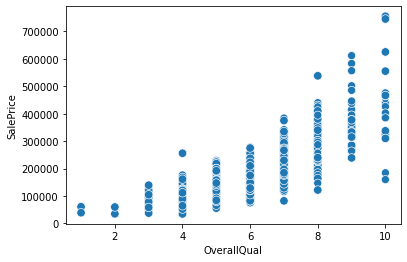

In [6]:
sns.scatterplot(data=home_train,x="OverallQual", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [7]:
#Drop SalePrice>300000 because we want remain around this price always having a good quality (in some cases also excellent quality)
home_train=home_train.drop(home_train[(home_train["OverallQual"]<3) & (home_train["SalePrice"]>300000)].index)

# 2.  For living Area(Above grade (ground) living area square feet)

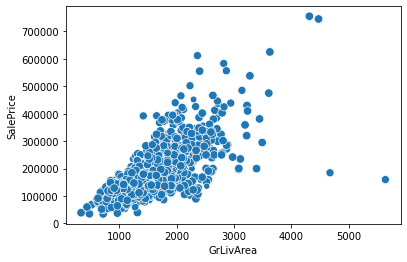

In [8]:
sns.scatterplot(data=home_train, x="GrLivArea", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [9]:
#Since there's outlier after 4000, we filter it out
home_train=home_train.drop(home_train[(home_train["GrLivArea"]>4000) & (home_train["SalePrice"]<300000)].index)

# 3. TotalBsmtSF (Total square feet of basement area)

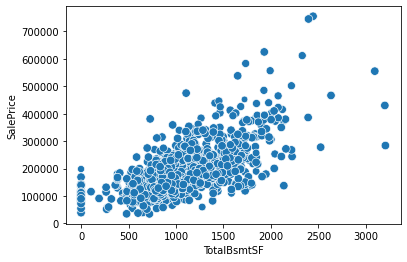

In [10]:
sns.scatterplot(data=home_train, x="TotalBsmtSF", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [11]:
#Since there's outlier after 3000, we filter it out

home_train=home_train.drop(home_train[(home_train["TotalBsmtSF"]>3000) & (home_train["SalePrice"]<300000)].index)

# 4. TotRmsAbvGrd (Total rooms above grade, does not include bathrooms)  
*IS IMPORTANT ONLY IF THE BUYER HAVE SOME REQUIREMENTS (FOR EXAMPLE ROOMS =>3)*

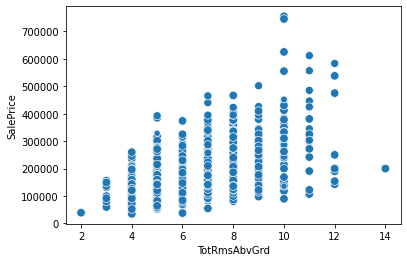

In [12]:
sns.scatterplot(data=home_train,x="TotRmsAbvGrd", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [13]:
#Drop SalePrice>300000 because we want remain around this price always having a discrete number of rooms (also depends from the requirements of different buyer)
#In this case i decided to drop the houses wich have less than 3 rooms
home_train=home_train.drop(home_train[(home_train["TotRmsAbvGrd"]<3) & (home_train["SalePrice"]>300000)].index)

# 5. YearBuilt (Original construction date)

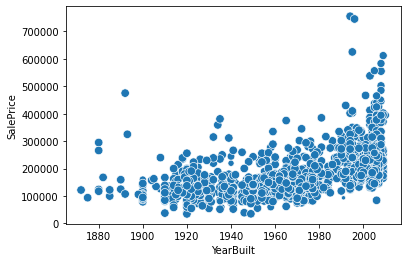

In [14]:
sns.scatterplot(data=home_train, x="YearBuilt", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [15]:
home_train=home_train.drop(home_train[(home_train['YearBuilt']<1910) & (home_train['SalePrice']>400000)].index)

# 6. OpenPorchSF(Open porch area in square feet)

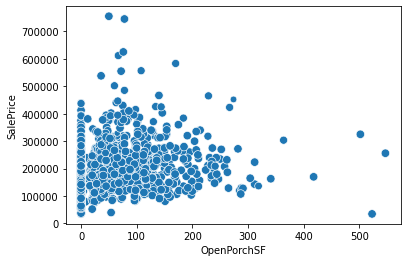

In [16]:
sns.scatterplot(data=home_train, x="OpenPorchSF", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [17]:
home_train=home_train.drop(home_train[(home_train['OpenPorchSF']>400) & (home_train['SalePrice']<100000)].index)

# 7. OverallCond (Overall condition rating)

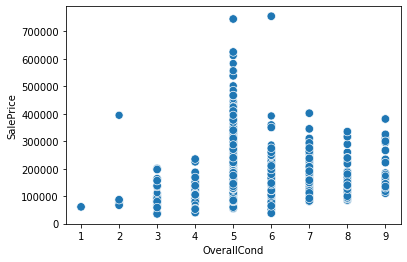

In [18]:
sns.scatterplot(data=home_train, x="OverallCond", y="SalePrice",size='SaleType')
plt.legend([],[], frameon=False)

In [19]:
#Drop SalePrice>300000 because we want remain around this price always having a good condition (in some cases also excellent condition)
home_train=home_train.drop(home_train[(home_train["OverallCond"]<3) & (home_train["SalePrice"]>300000)].index)

# Plot Correlation Matrix

<AxesSubplot:>

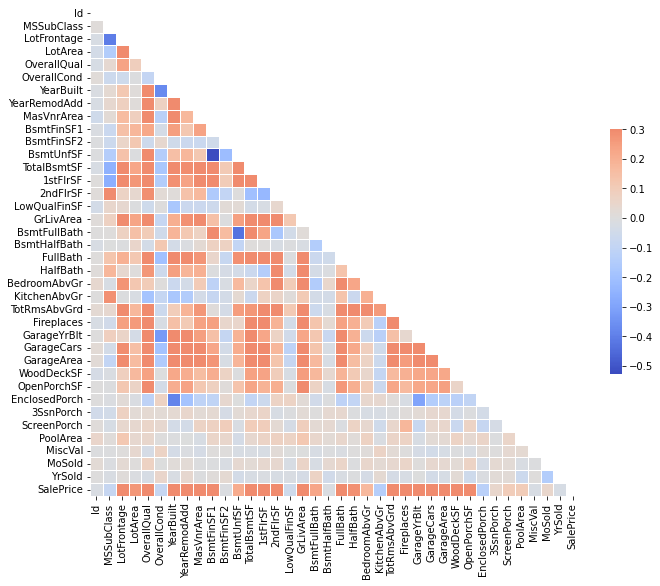

In [20]:
corr = home_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Distribution of the Target**

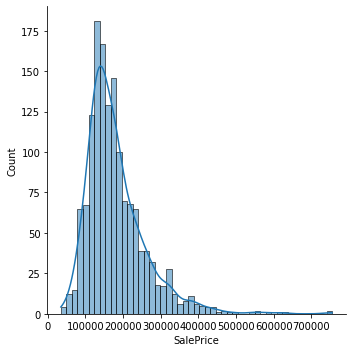

In [21]:
from scipy.stats import norm

sns.displot(data=home_train, x="SalePrice", kde=True)
  

In that way we check the skewness of the Target Variable "SalePrice". It is right skewed distribution and so we apply log function on the Target variable during the X,y split.

# **Data Processing**

First we join all the data together, so it'll be easier and less time consumption when we do data processing, encoding which makes the train and test data ready for model at the same time.

In [22]:
tot_data= pd.concat([home_train, home_test])
tot_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


# **Combining Data and Creating New Features**

In [23]:
tot_data['MSSubClass'] = tot_data['MSSubClass'].astype(str)
tot_data['Year'] = tot_data['YrSold'] - tot_data['YearBuilt']
tot_data['Total_Area'] = tot_data['GrLivArea'] + tot_data['TotalBsmtSF'] + tot_data['GarageArea'] + tot_data['LotArea']*0.1
tot_data['Overall_Plus'] = tot_data['OverallQual'] + tot_data['OverallCond']
tot_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Year,Total_Area,Overall_Plus
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2008,WD,Normal,208500.0,5,3959.0,12
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,5,2007,WD,Normal,181500.0,31,3944.0,14
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,9,2008,WD,Normal,223500.0,7,4439.0,12
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,2,2006,WD,Abnorml,140000.0,91,4070.0,12
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,12,2008,WD,Normal,250000.0,8,5605.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,6,2006,WD,Normal,NaN,36,1831.6,11
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,4,2006,WD,Abnorml,NaN,36,2113.4,9
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,9,2006,WD,Abnorml,NaN,46,5024.0,12
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,Shed,700,7,2006,WD,Normal,NaN,14,2926.1,10


Now, we decide to drop the "Id" feature and the target variable "SalePrice" from the training data. 

Dropping the "Id" from the training data is useful because it prevents the model from learning to predict the "Id", which would not be useful for the task at hand and could lead to overfitting which occurs when a model becomes too closely fit to the training data, resulting in poor performance on new unseen data.

Dropping the target variable "SalePrice", instead, from the training data is useful because it ensures that the model is not able to memorize the target values during the training process. This ensures that the model is able to generalize well to new, unseen data during the testing phase, and makes the model more robust to variations in the input data. Also in this case, this helps to prevent overfitting.

In [24]:
tot_data2 = tot_data.drop(columns = ['Id', 'SalePrice'])
tot_data3 = pd.get_dummies(tot_data2)
tot_data3 = tot_data3.fillna(-1)

#Scaling the Feature Values/
rs = RobustScaler()
tot_data4 = rs.fit_transform(tot_data3)
tot_data4 = pd.DataFrame(tot_data4, columns=tot_data3.columns)

In [25]:
#Reassigning Id Values to the Test Data
new_id = tot_data['Id'].to_list()

tot_data4['Id'] = new_id

tot_data5 = tot_data4

train2 = tot_data5[:len(home_train)]
train2 = train2.drop('Id', axis=1)

test2 = tot_data5[len(home_train):]
test2 = test2.set_index('Id')

In [26]:
tot_data5.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,0.057143,-0.244858,0.5,0.0,0.638298,0.256410,1.209877,0.461749,0.0,-0.543739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.485714,0.036729,0.0,3.0,0.063830,-0.435897,0.000000,0.833333,0.0,-0.313894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.142857,0.440744,0.5,0.0,0.595745,0.230769,1.000000,0.161202,0.0,-0.056604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,-0.085714,0.024486,0.5,0.0,-1.234043,-0.589744,0.000000,-0.207650,0.0,0.125214,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,4
4,0.600000,1.177767,1.0,0.0,0.574468,0.179487,2.160494,0.392077,0.0,0.039451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


# **Modelling**

In [27]:
#np.log1p(x) is useful when the data contains zero or negative values,as the natural logarithm of x is not defined for x <= 0. 
#By adding 1 to the input, log1p allows to apply logarithmic transformation to data which may contain zero or negative values
X_train, X_val, y_train, y_val = train_test_split(train2, np.log1p(home_train['SalePrice']), test_size = 0.2, random_state = 42, shuffle = True)

# **Catboost vs XGBoost Regression KFold Cross Validation (5 Folds) Model**

CatBoost builds symmetric (balanced) trees, XGBoost asymmetric. 
In this case CatBoost is better and we prove it

In [28]:
# Number of folds
n_folds = 5
result_cat=0
y = np.log(home_train['SalePrice'])

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True)

# Create the CatBoostRegressor object
model_cat = CatBoostRegressor(iterations=4000, verbose=500, eval_metric='MAE', max_depth=6, subsample=0.7, learning_rate=0.04)

# Initialize the array to store the scores
scores = []

# Perform the cross-validation
for fold, (train_index, val_index) in enumerate (kf.split(train2)):
    X_train, X_val = train2.iloc[train_index], train2.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model on the training data
    model_cat.fit(X_train, y_train)
    
    # Get the score on the validation data
    score = model_cat.score(X_val, y_val)
    
    # Append the score to the scores array
    scores.append(score)
    
    #print the MAE for each fold
    print("Fold", fold+1,"MAE CatBoost:", mean_absolute_error(np.exp(y_val), np.exp(model_cat.predict(X_val)))) 
    
result_cat += np.exp(model_cat.predict(test2)) / 5


# Print the mean and standard deviation of the scores
print("Mean score CatBoost:", np.mean(scores)) # mean of the scores obtained on each fold

print("Standard deviation CatBoost:", np.std(scores)) # idea of how much the score varies across the different folds.



# XGBoost part
# Number of folds
n_folds = 5
result_xg=0
y = np.log(home_train['SalePrice'])

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True)

# Create the CatBoostRegressor object
model_xg = XGBRegressor(n_estimators=4000,max_depth=6, subsample=0.7, learning_rate=0.04)

# Initialize the array to store the scores
scores = []

# Perform the cross-validation
for fold, (train_index, val_index) in enumerate (kf.split(train2)):
    X_train, X_val = train2.iloc[train_index], train2.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model on the training data
    model_xg.fit(X_train, y_train)
    
    # Get the score on the validation data
    score = model_xg.score(X_val, y_val)
    
    # Append the score to the scores array
    scores.append(score)
    
    #print the MAE for each fold
    print("Fold", fold+1,"MAE XGBoost:", mean_absolute_error(np.exp(y_val), np.exp(model_xg.predict(X_val)))) 
    
result_xg += np.exp(model_xg.predict(test2)) / 5


# Print the mean and standard deviation of the scores
print("Mean score XGBoost:", np.mean(scores)) # mean of the scores obtained on each fold

print("Standard deviation XGBoost:", np.std(scores)) # idea of how much the score varies across the different folds.

0:	learn: 0.3033224	total: 58.1ms	remaining: 3m 52s
500:	learn: 0.0469521	total: 1.5s	remaining: 10.5s
1000:	learn: 0.0289693	total: 2.97s	remaining: 8.9s
1500:	learn: 0.0183809	total: 4.47s	remaining: 7.45s
2000:	learn: 0.0122069	total: 6.12s	remaining: 6.12s
2500:	learn: 0.0083315	total: 7.64s	remaining: 4.58s
3000:	learn: 0.0058933	total: 9.16s	remaining: 3.05s
3500:	learn: 0.0041476	total: 10.7s	remaining: 1.53s
3999:	learn: 0.0029632	total: 12.2s	remaining: 0us
Fold 1 MAE CatBoost: 11693.35773022886
0:	learn: 0.2951891	total: 3.71ms	remaining: 14.9s
500:	learn: 0.0446528	total: 1.43s	remaining: 10s
1000:	learn: 0.0264872	total: 2.87s	remaining: 8.6s
1500:	learn: 0.0162652	total: 4.33s	remaining: 7.2s
2000:	learn: 0.0106491	total: 5.75s	remaining: 5.75s
2500:	learn: 0.0071352	total: 7.14s	remaining: 4.28s
3000:	learn: 0.0048395	total: 8.6s	remaining: 2.86s
3500:	learn: 0.0033762	total: 10s	remaining: 1.43s
3999:	learn: 0.0023894	total: 11.4s	remaining: 0us
Fold 2 MAE CatBoost: 1444

Indeed, in this case, the best method between CatBoost and XGBoost is the first.
In addition we decide to compute and evaluate three parameters: MAE, mean and the standard deviation but the better method to apply in our case is the MAE.
This because, when the data has outliers or is skewed, the mean can be affected and may not be a good measure of central tendency. In this case, the mean absolute error (MAE) may be a better measure as it is more robust to outliers

# ****Ridge Regression KFold Cross Validation (5 Folds) Model****

In [29]:
n_folds = 5
result_ridge = 0
y = np.log(home_train['SalePrice'])

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True)

# Create the CatBoostRegressor object

model_ridge = Ridge(alpha = 10)
# Initialize the array to store the scores
scores = []

# Perform the cross-validation
for fold, (train_index, val_index) in enumerate (kf.split(train2)):
    X_train, X_val = train2.iloc[train_index], train2.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model on the training data
    model_ridge.fit(X_train, y_train)
    
    # Get the score on the validation data
    score = model_ridge.score(X_val, y_val)


    # Append the score to the scores array
    scores.append(score)

    #print the MAE for each fold
    print("Fold", fold+1,"MAE:", mean_absolute_error(np.exp(y_val), np.exp(model_ridge.predict(X_val)))) 

    
result_ridge += np.exp(model_ridge.predict(test2)) / 5

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores)) # mean of the scores obtained on each fold
print("Standard deviation:", np.std(scores)) # idea of how much the score varies across the different folds

Fold 1 MAE: 14094.04245532912
Fold 2 MAE: 12694.655654290764
Fold 3 MAE: 13124.046970468882
Fold 4 MAE: 13852.4478298772
Fold 5 MAE: 12084.229841667737
Mean score: 0.9201962862448345
Standard deviation: 0.014540331470407756


# **Exporting Output**

In [30]:
# Save test predictions to file
output = pd.DataFrame({'Id': test2.index,
                       'SalePrice':  result_cat * 0.5 + result_ridge * 0.5})
output.to_csv('submission.csv', index=False)
output

,Id,SalePrice
0,1461,24121.157565
1,1462,29994.691380
2,1463,37091.189417
3,1464,39035.413435
4,1465,37574.367751
...,...,...
1454,2915,17020.581925
1455,2916,16172.194419
1456,2917,32965.871097
1457,2918,22949.014816


# **Conclusion**

We want obtain a model which making a good predictions and therefore which have the good accuracy, interpretability and robustness. In order to making a good predictions the Data Processing plays a vital role. With Processing means Scaling, Encoding, Filling with mean and making new features based on existing ones. This "operations" will be very helpful in building more complex models.